In [1]:
import os
from scipy.io.wavfile import read, write
import librosa
import torch
import numpy as np

from uberduck_ml_dev.data.get import get
from uberduck_ml_dev.data.utils import mel_spectrogram_torch, find_rel_paths
from uberduck_ml_dev.data.data import HIFIGAN_DEFAULTS as DEFAULTS
from uberduck_ml_dev.data.data import MAX_WAV_VALUE


data_directory = "/usr/src/app/uberduck_ml_exp/data/lj_redo/"
ground_truth_rel_paths = find_rel_paths(directory=data_directory, filename="gt.wav")
ground_truth_abs_paths = [
    os.path.join(data_directory, ground_truth_rel_path)
    for ground_truth_rel_path in ground_truth_rel_paths
]

resampled_normalized_abs_paths = [
    resampled_normalized_abs_path.replace(
        "gt.wav", "audio_resampledT_normalized32768T.wav"
    )
    for resampled_normalized_abs_path in ground_truth_abs_paths
]

spectrogram_abs_paths = [
    ground_truth_abs_path.replace("gt.wav", "spectrogram.pt")
    for ground_truth_abs_path in ground_truth_abs_paths
]

resampled_float_normalized_abs_paths = [
    ground_truth_abs_path.replace(
        "gt.wav", "audio_resampledT_normalized1T.wav"
    )
    for ground_truth_abs_path in ground_truth_abs_paths
]


In [4]:
folder_abs_paths = [
    ground_truth_abs_path.split('/gt.wav')[0]
    for ground_truth_abs_path in ground_truth_abs_paths
]

In [6]:
import pandas as pd
import csv
pd.DataFrame(folder_abs_paths).to_csv('/usr/src/app/uberduck_ml_exp/filelists/lj_hifigan.txt', sep = '|', header = None,
                                     index = None, quoting = csv.QUOTE_NONE)

In [11]:

print("resampling and float/1 normalizing spectrograms")

loading_function = lambda filename: librosa.load(filename, sr=22050)[0]
processing_function = lambda x: np.asarray(
    (x / np.abs(x).max()) * (1 - 1 / MAX_WAV_VALUE), dtype=np.float32
)
saving_function = lambda data, filename: write(
    filename, 22050, data
)  # must be in this order


get(
    processing_function,
    saving_function,
    loading_function,
    ground_truth_abs_paths,
    resampled_float_normalized_abs_paths,
    True,
)


resampling and float/1 normalizing spectrograms


In [8]:

print("resampling and integer/32768 normalizing spectrograms")



loading_function = lambda filename: librosa.load(filename, sr=22050)[0]
processing_function = lambda x: np.asarray(
    (x / np.abs(x).max()) * (MAX_WAV_VALUE - 1), dtype=np.int16
)
saving_function = lambda data, filename: write(
    filename, 22050, data
)  # must be in this order


get(
    processing_function,
    saving_function,
    loading_function,
    ground_truth_abs_paths,
    resampled_normalized_abs_paths,
    False,
)


print("compute spectrograms")





resampling and integer/32768 normalizing spectrograms
compute spectrograms


In [9]:


processing_function = lambda x: mel_spectrogram_torch(
    x,
    DEFAULTS["n_fft"],
    DEFAULTS['num_mels'],
    DEFAULTS["sampling_rate"],
    DEFAULTS["hop_size"],
    DEFAULTS["win_size"],
    DEFAULTS["fmin"],
    DEFAULTS["fmax"],
    True,
)
loading_function = lambda source_path: torch.Tensor(read(source_path)[1] / MAX_WAV_VALUE).unsqueeze(0)
saving_function = lambda data, target_path: torch.save(data[0], target_path)

get(
    processing_function,
    saving_function,
    loading_function,
    resampled_normalized_abs_paths,
    spectrogram_abs_paths,
    True,
)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
/usr/local/lib/python3.8/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # typ

<Axes: >

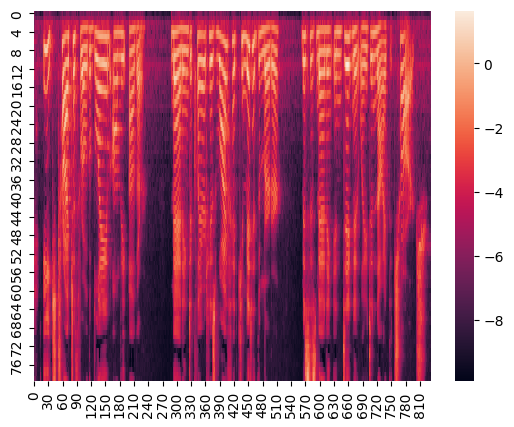

In [3]:
%matplotlib inline
import seaborn as sns
sns.heatmap(torch.load(spectrogram_abs_paths[0])[0])

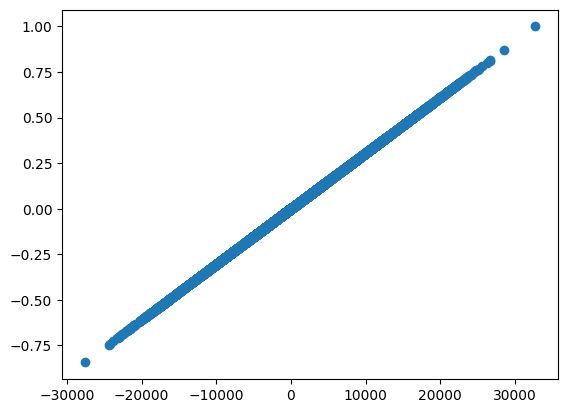

In [13]:
import matplotlib.pyplot as plt
plt.scatter(read(resampled_normalized_abs_paths[0])[1], read(resampled_float_normalized_abs_paths[0])[1])

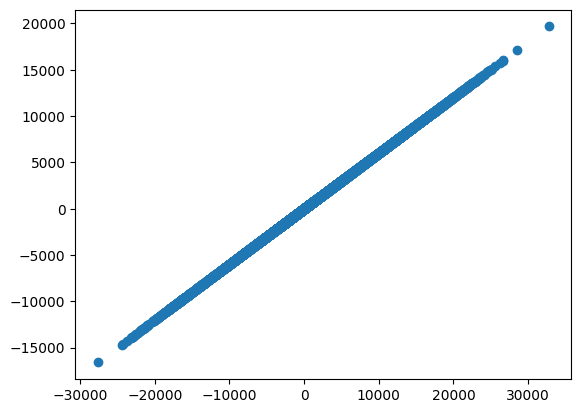

In [14]:
import matplotlib.pyplot as plt
plt.scatter(read(resampled_normalized_abs_paths[0])[1], read(ground_truth_abs_paths[0])[1])